# Chapter 116: QSVT

---

**Prerequisites:**
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime import Estimator
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp
from IPython.display import display
from numpy.polynomial.chebyshev import Chebyshev
from pyqsp.angle_sequence import QuantumSignalProcessingPhases
from Chapter16_QSVT_functions import myQSVT, get_inverse_phases,get_total_error_vs_unscaled_ideal, plot_approximation_comparison

## Quantum Signal Processing 

In [2]:
# Define polynomial coefficients: P(a) = 2a^2 - 1
# Coefficients in monomial basis: [a^0, a^1, a^2]
pcoefs = [-1, 0, 2]

# Convert from monomial to Chebyshev basis (required by pyqsp)
pcoefs_cheb = np.polynomial.chebyshev.poly2cheb(pcoefs)

# Create Chebyshev polynomial object
poly = Chebyshev(pcoefs_cheb)

# Compute QSP phase angles
phases = QuantumSignalProcessingPhases(poly, signal_operator="Wz")

print("Polynomial: P(a) = 2a² - 1")
print([float(phi) for phi in phases])




Polynomial: P(a) = 2a² - 1
[-0.7903984342278787, 9.547918011776346e-15, 0.7803978925670181]


In [3]:
kappa = 10
eps = 0.01
d = int(3*kappa*np.log(1/eps))

if d % 2 == 0:
    d += 1

print(f"Degree d={d} for kappa={kappa} and eps={eps}")
err = get_total_error_vs_unscaled_ideal(d, kappa)
print(f"Total error vs unscaled ideal: {err}")

Degree d=139 for kappa=10 and eps=0.01
Total error vs unscaled ideal: 0.010929726252616234


## QSVT example

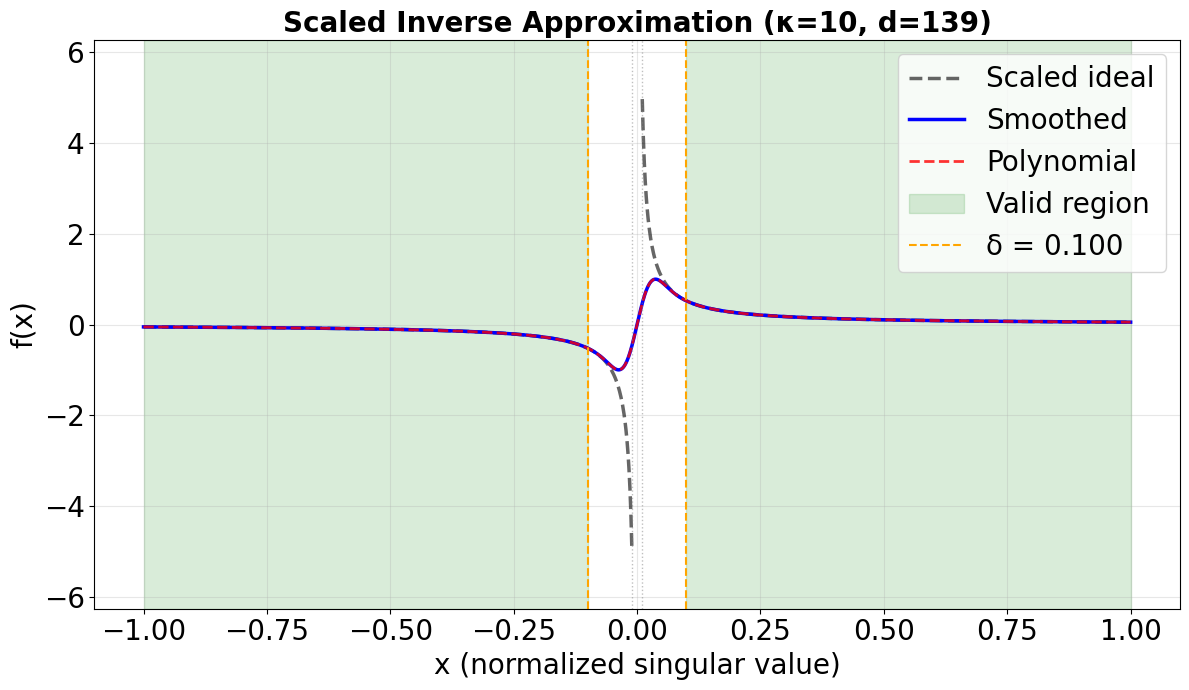

In [4]:

plot_approximation_comparison(d, kappa)


## Inversion

In [5]:
A = np.array([[0.5, -0.25], [-0.25, 0.5]])
sigma_vals = np.linalg.svd(A, compute_uv=False)
A = A / (1.001*np.max(sigma_vals))  # Scale to have max singular value = 1
sigma_vals = np.linalg.svd(A, compute_uv=False)
print("Singular values of A:", sigma_vals)
b = np.array([1, 0]) # State |0>
degree = 5
kappa = np.max(sigma_vals) / np.min(sigma_vals)
print(f"Condition number kappa={kappa}")
solver = myQSVT(A, b, degree, kappa, nShots=1000)


u_qsvt = solver.execute()

if u_qsvt is not None:
    print("QSVT Solution (|x>):", u_qsvt)
    
    # Classical Verification
    x_exact = np.linalg.solve(A, b)
    u_exact = x_exact / np.linalg.norm(x_exact)
    print("Classical Solution: ", u_exact)
    print("Fidelity:           ", np.abs(np.dot(u_qsvt.conj(), u_exact))**2)

Singular values of A: [0.999001   0.33300033]
Condition number kappa=3.000000000000001
Generated 6 angles for degree 5
Circuit width (total qubits): 4
Circuit depth: 25
QSVT Solution (|x>): [0.86833789 0.49597309]
Classical Solution:  [0.89442719 0.4472136 ]
Fidelity:            0.9969441983606572
